In [1]:
# Install libraries
# !pip install psutil
# !pip install tqdm
# !pip install statsmodels
# !pip install scipy

In [2]:
import os
import glob
import pandas as pd
import psutil
from tqdm import tqdm


- This project will focus solely on datasets named in the format **dot1_MMYY**, **dot2_MMYY**, and **dot3_MMYY**, where the suffix represents the month and year.

- Since the data is organized into five main folders (**2020**, **2021**, **2022**, **2023**, and **2024**), each containing subfolders for the months with their respective datasets, a **for loop** will be used to iterate through them for processing.
- #### Estimating Optimal Chunk Size

To efficiently process large CSV files, a small sample of 1,000 rows is read to estimate the average memory usage per row. The script then calculates 10% of the system’s available RAM and divides it by the average row size to determine the optimal `chunksize` — the number of rows that can be safely processed at a time without overloading memory.

```python
chunksize = int(memory_budget / row_size)


In [4]:
import os
import glob
import pandas as pd
import psutil
from tqdm import tqdm

# 1. Calculate Optimal Chunk Size Based on Available Memory

sample_file = r"C:\Users\kpbon\Desktop\Azubi Africa\Project 1\data\2020\April2020TransBorderRawData\Apr 2020\dot1_0420.csv"
sample_df = pd.read_csv(sample_file, nrows=1000)  # Load a sample to estimate row size
row_size = sample_df.memory_usage(deep=True).sum() / 1000  # Average size per row (bytes)
memory_budget = psutil.virtual_memory().available * 0.1  # Use 10% of available RAM
chunksize = int(memory_budget / row_size)  # Rows per chunk

print('------------------------------------------------------')
print(f"Using chunk size: {chunksize}")
print('------------------------------------------------------')

# 2. Setup Main Folder and Dataset Storage

data_folder = r'C:\Users\kpbon\Desktop\Azubi Africa\Project 1\data'
data_dict = {'dot1': [], 'dot2': [], 'dot3': []}  # Store combined chunks by type

# 3. Month Name to Month Number Mapping

month_mapping = {
    "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
    "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
}

# 4. Loop Through All Year Folders (2020–2024)

for year in tqdm(['2020', '2021', '2022', '2023', '2024'], desc="Processing Years"):
    year_path = os.path.join(data_folder, year)

    # Loop through wrapper folders like "April2020TransBorderRawData"
    for wrapper_folder in tqdm(os.listdir(year_path), desc=f"Processing folders in {year}"):
        wrapper_path = os.path.join(year_path, wrapper_folder)

        # Skip if it's not a directory
        if not os.path.isdir(wrapper_path):
            continue

        # Loop through actual month folders like "Apr 2020"
        for month_folder in os.listdir(wrapper_path):
            month_path = os.path.join(wrapper_path, month_folder)

            # Extract month and year
            if " " not in month_folder:
                continue  # Skip folders not in expected format

            month_name, folder_year = month_folder.split(" ")
            month_number = month_mapping.get(month_name[:3])
            file_suffix = f"_{month_number}{year[-2:]}"  # E.g., _0420

            # 5. Identify Files with Expected Names and Extensions

            pattern = os.path.join(month_path, f"dot*{file_suffix}.*")
            all_files = glob.glob(pattern)
            target_files = [
                f for f in all_files
                if os.path.basename(f) in [
                    f"dot1{file_suffix}.csv", f"dot2{file_suffix}.csv", f"dot3{file_suffix}.csv",
                    f"dot1{file_suffix}.xlsx", f"dot2{file_suffix}.xlsx", f"dot3{file_suffix}.xlsx",
                    f"dot1{file_suffix}.xls",  f"dot2{file_suffix}.xls",  f"dot3{file_suffix}.xls"
                ]
            ]

            # 6. Read Each File by Chunk and Store in Corresponding Type

            for file in tqdm(target_files, desc=f"Reading files in {month_folder}"):
                dataset_type = os.path.basename(file).split('_')[0]

                try:
                    if file.endswith('.csv'):
                        for chunk in pd.read_csv(file, chunksize=chunksize):
                            data_dict[dataset_type].append(chunk)
                    elif file.endswith(('.xlsx', '.xls')):
                        df = pd.read_excel(file)
                        data_dict[dataset_type].append(df)
                except Exception as e:
                    print(f"Error reading file {file}: {e}")

# 7. Concatenate All Chunks into Final DataFrames

all_dot1 = pd.concat(data_dict['dot1'], ignore_index=True) if data_dict['dot1'] else pd.DataFrame()
all_dot2 = pd.concat(data_dict['dot2'], ignore_index=True) if data_dict['dot2'] else pd.DataFrame()
all_dot3 = pd.concat(data_dict['dot3'], ignore_index=True) if data_dict['dot3'] else pd.DataFrame()

# 8. Print Final Dataset Shapes

print('------------------------------------------------------')
print('All dot1 shape:', all_dot1.shape)
print('All dot2 shape:', all_dot2.shape)
print('All dot3 shape:', all_dot3.shape)
print('------------------------------------------------------')


------------------------------------------------------
Using chunk size: 497803
------------------------------------------------------


Processing folders in 2020:   0%|                                                                | 0/9 [00:00<?, ?it/s]

Reading files in Apr 2020:   0%|                                                                 | 0/3 [00:00<?, ?it/s]

Reading files in Apr 2020: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.36it/s]

Processing folders in 2020:  11%|██████▏                                                 | 1/9 [00:00<00:02,  3.38it/s]

Reading files in Feb 2020:   0%|                                                                 | 0/3 [00:00<?, ?it/s]C:\Users\kpbon\AppData\Local\Temp\ipykernel_15764\500587952.py:76: DtypeWarning: Columns (4,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunksize):


Reading files in Feb 2020: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.24it/s]

Processing folders in 2020:  33%|████████████████

------------------------------------------------------
All dot1 shape: (214171, 14)
All dot2 shape: (585849, 14)
All dot3 shape: (135189, 12)
------------------------------------------------------


### DOT1: Dataset Summary
This section provides a concise overview of the DOT1 dataset, including:
- The number of rows and columns
- Column data types
- Memory usage
- Non-null counts per column


In [6]:
print("\n========== DOT1 Dataset Summary ==========")
print(all_dot1.info())



========== DOT1 Dataset Summary ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214171 entries, 0 to 214170
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TRDTYPE          214171 non-null  int64  
 1   USASTATE         214171 non-null  object 
 2   DEPE             214171 non-null  object 
 3   DISAGMOT         214171 non-null  int64  
 4   MEXSTATE         61209 non-null   object 
 5   CANPROV          136751 non-null  object 
 6   COUNTRY          214171 non-null  int64  
 7   VALUE            214171 non-null  int64  
 8   SHIPWT           214171 non-null  int64  
 9   FREIGHT_CHARGES  214171 non-null  int64  
 10  DF               133167 non-null  float64
 11  CONTCODE         214171 non-null  object 
 12  MONTH            214171 non-null  int64  
 13  YEAR             214171 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 22.9+ MB
None


In [7]:
print("\n========== DOT2 Dataset Summary ==========")
print(all_dot2.info())



========== DOT2 Dataset Summary ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585849 entries, 0 to 585848
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TRDTYPE          585849 non-null  int64  
 1   USASTATE         585849 non-null  object 
 2   COMMODITY2       585849 non-null  int64  
 3   DISAGMOT         585849 non-null  int64  
 4   MEXSTATE         196421 non-null  object 
 5   CANPROV          353611 non-null  object 
 6   COUNTRY          585849 non-null  int64  
 7   VALUE            585849 non-null  int64  
 8   SHIPWT           585849 non-null  int64  
 9   FREIGHT_CHARGES  585849 non-null  int64  
 10  DF               406105 non-null  float64
 11  CONTCODE         585849 non-null  object 
 12  MONTH            585849 non-null  int64  
 13  YEAR             585849 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 62.6+ MB
None


In [8]:
print("\n========== DOT3 Dataset Summary ==========")
print(all_dot3.info())



========== DOT3 Dataset Summary ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135189 entries, 0 to 135188
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TRDTYPE          135189 non-null  int64  
 1   DEPE             135189 non-null  object 
 2   COMMODITY2       135189 non-null  int64  
 3   DISAGMOT         135189 non-null  int64  
 4   COUNTRY          135189 non-null  int64  
 5   VALUE            135189 non-null  int64  
 6   SHIPWT           135189 non-null  int64  
 7   FREIGHT_CHARGES  135189 non-null  int64  
 8   DF               80752 non-null   float64
 9   CONTCODE         135189 non-null  object 
 10  MONTH            135189 non-null  int64  
 11  YEAR             135189 non-null  int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 12.4+ MB
None


### UNDERSTANDING THE DATASET

DOT 1, DOT 2, and DOT 3 have different sets of columns. However, they all share the following 10 columns:  
**TRDTYPE**, **DISAGMOT**, **COUNTRY**, **VALUE**, **SHIPWT**, **FREIGHT_CHARGES**, **DF**, **CONTCODE**, **MONTH**, and **YEAR**.

In addition:
- **DOT 1** and **DOT 2** have **three additional columns** in common: **USASTATE**, **MEXSTATE**, and **CANPROV**.
- **DOT 1** and **DOT 3** share **one additional column**: **DEPE**.
- **DOT 2** and **DOT 3** share **one additional column**: **COMMODITY2**.

- **Note**: This will result in null values for the columns that are not in all of them when the data is merged


### Missing Values Check
This step helps identify columns with missing data and how many null values each contains.


In [11]:
print("\nMissing values in dot1:")
print(all_dot1.isnull().sum())



Missing values in dot1:
TRDTYPE                 0
USASTATE                0
DEPE                    0
DISAGMOT                0
MEXSTATE           152962
CANPROV             77420
COUNTRY                 0
VALUE                   0
SHIPWT                  0
FREIGHT_CHARGES         0
DF                  81004
CONTCODE                0
MONTH                   0
YEAR                    0
dtype: int64


In [12]:
print("\nMissing values in dot2:")
print(all_dot2.isnull().sum())



Missing values in dot2:
TRDTYPE                 0
USASTATE                0
COMMODITY2              0
DISAGMOT                0
MEXSTATE           389428
CANPROV            232238
COUNTRY                 0
VALUE                   0
SHIPWT                  0
FREIGHT_CHARGES         0
DF                 179744
CONTCODE                0
MONTH                   0
YEAR                    0
dtype: int64


In [13]:
print("\nMissing values in dot3:")
print(all_dot3.isnull().sum())


Missing values in dot3:
TRDTYPE                0
DEPE                   0
COMMODITY2             0
DISAGMOT               0
COUNTRY                0
VALUE                  0
SHIPWT                 0
FREIGHT_CHARGES        0
DF                 54437
CONTCODE               0
MONTH                  0
YEAR                   0
dtype: int64


In [14]:
merged_data = pd.concat([all_dot1, all_dot2, all_dot3], ignore_index = True)

In [15]:
merged_data.shape

(935209, 15)

In [16]:
merged_data.head()

,TRDTYPE,USASTATE,DEPE,DISAGMOT,MEXSTATE,CANPROV,COUNTRY,VALUE,SHIPWT,FREIGHT_CHARGES,DF,CONTCODE,MONTH,YEAR,COMMODITY2
0,1,AK,0115,5,NaN,XB,1220,4660,0,67,2.0,X,4,2020,NaN
1,1,AK,0901,5,NaN,XO,1220,14360,0,282,1.0,X,4,2020,NaN
2,1,AK,20XX,1,XX,NaN,2010,4293733,24971000,0,1.0,0,4,2020,NaN
3,1,AK,20XX,3,NaN,XA,1220,28283,443,563,1.0,X,4,2020,NaN
4,1,AK,20XX,3,NaN,XA,1220,29848,69,538,2.0,X,4,2020,NaN


In [17]:
merged_data['CONTCODE'].unique()

array(['X', '0', '1', 0, 1], dtype=object)

### Interpretation of `CONTCODE` (Container Code)

- `'X'` - **Containerized**  
- `'0'` - **Non-Containerized**  
- `'1'` - **Unknown** (no official match found, assumed based on absence of definition)

To make the data more meaningful during analysis, I assigned:
- `'X'` as **"Containerized"**
- `'0'` as **"Non-Containerized"**
- `'1'` as **"Unknown"**, since it had no documented explanation


In [19]:
merged_data['CONTCODE'] = merged_data['CONTCODE'].replace({'X': 'Containerized', '0': 'Non-Containerized',
                                                         0: 'Non-Containerized', '1': 'Unknown', 1: 'Unknown'})

In [20]:
merged_data['CONTCODE'].unique()

array(['Containerized', 'Non-Containerized', 'Unknown'], dtype=object)

In [21]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935209 entries, 0 to 935208
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TRDTYPE          935209 non-null  int64  
 1   USASTATE         800020 non-null  object 
 2   DEPE             349360 non-null  object 
 3   DISAGMOT         935209 non-null  int64  
 4   MEXSTATE         257630 non-null  object 
 5   CANPROV          490362 non-null  object 
 6   COUNTRY          935209 non-null  int64  
 7   VALUE            935209 non-null  int64  
 8   SHIPWT           935209 non-null  int64  
 9   FREIGHT_CHARGES  935209 non-null  int64  
 10  DF               620024 non-null  float64
 11  CONTCODE         935209 non-null  object 
 12  MONTH            935209 non-null  int64  
 13  YEAR             935209 non-null  int64  
 14  COMMODITY2       721038 non-null  float64
dtypes: float64(2), int64(8), object(5)
memory usage: 107.0+ MB


In [22]:
merged_data.nunique()

TRDTYPE                 2
USASTATE               52
DEPE                  241
DISAGMOT                8
MEXSTATE               33
CANPROV                14
COUNTRY                 2
VALUE              430405
SHIPWT             153131
FREIGHT_CHARGES     86711
DF                      2
CONTCODE                3
MONTH                   7
YEAR                    2
COMMODITY2             98
dtype: int64

In [23]:
# Define mapping dictionaries
trdtype_map = {1: 'Export', 2: 'Import'}

disagmot_map = {
    1: 'Vessel', 3: 'Air', 4: 'Mail (U.S. Postal Service)', 5: 'Truck',
    6: 'Rail', 7: 'Pipeline', 8: 'Unknown', 9: 'Barge',
    10: 'Other', 11: 'Flyaway aircraft', 12: 'Fixed P&T equipment'
}

country_map = {
    2010: 'Canada', 2011: 'Mexico'
}

df_map = {
    1: 'Domestic', 2: 'Foreign'
}

mexstate_map = {
    1: 'Aguascalientes', 2: 'Baja California', 3: 'Baja California Sur',
    4: 'Campeche', 5: 'Chiapas', 6: 'Chihuahua', 7: 'Coahuila', 8: 'Colima',
    9: 'Durango', 10: 'Guanajuato', 11: 'Guerrero', 12: 'Hidalgo', 13: 'Jalisco',
    14: 'Mexico', 15: 'Michoacán', 16: 'Morelos', 17: 'Nayarit', 18: 'Nuevo León',
    19: 'Oaxaca', 20: 'Puebla', 21: 'Querétaro', 22: 'Quintana Roo', 23: 'San Luis Potosí',
    24: 'Sinaloa', 25: 'Sonora', 26: 'Tabasco', 27: 'Tamaulipas', 28: 'Tlaxcala',
    29: 'Veracruz', 30: 'Yucatán', 31: 'Zacatecas', 32: 'Federal District'
}

canprov_map = {
    1: 'Alberta', 2: 'British Columbia', 3: 'Manitoba', 4: 'New Brunswick',
    5: 'Newfoundland and Labrador', 6: 'Nova Scotia', 7: 'Ontario',
    8: 'Prince Edward Island', 9: 'Quebec', 10: 'Saskatchewan',
    11: 'Northwest Territories', 12: 'Nunavut', 13: 'Yukon'
}

usastate_map = {
    1: 'Alabama', 2: 'Alaska', 4: 'Arizona', 5: 'Arkansas', 6: 'California',
    8: 'Colorado', 9: 'Connecticut', 10: 'Delaware', 11: 'District of Columbia',
    12: 'Florida', 13: 'Georgia', 15: 'Hawaii', 16: 'Idaho', 17: 'Illinois',
    18: 'Indiana', 19: 'Iowa', 20: 'Kansas', 21: 'Kentucky', 22: 'Louisiana',
    23: 'Maine', 24: 'Maryland', 25: 'Massachusetts', 26: 'Michigan', 27: 'Minnesota',
    28: 'Mississippi', 29: 'Missouri', 30: 'Montana', 31: 'Nebraska', 32: 'Nevada',
    33: 'New Hampshire', 34: 'New Jersey', 35: 'New Mexico', 36: 'New York',
    37: 'North Carolina', 38: 'North Dakota', 39: 'Ohio', 40: 'Oklahoma',
    41: 'Oregon', 42: 'Pennsylvania', 44: 'Rhode Island', 45: 'South Carolina',
    46: 'South Dakota', 47: 'Tennessee', 48: 'Texas', 49: 'Utah', 50: 'Vermont',
    51: 'Virginia', 53: 'Washington', 54: 'West Virginia', 55: 'Wisconsin',
    56: 'Wyoming'
}

contcode_map = {
    1: 'Not Containerized', 2: 'Containerized', 3: 'Not Applicable'
}

month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}



In [24]:
# Mapping for COMMODITY2
commodity2_map = {
    1: 'Live animals and meat',
    2: 'Dairy, eggs, honey',
    3: 'Other animal products',
    4: 'Live trees and plants',
    5: 'Vegetables',
    6: 'Fruit and nuts',
    7: 'Coffee, tea, spices',
    8: 'Cereals',
    9: 'Products of milling industry',
    10: 'Oil seeds, oleaginous fruits',
    11: 'Misc. grains, seeds',
    12: 'Lac, gums, resins',
    13: 'Vegetable plaiting materials',
    14: 'Animal or vegetable fats and oils',
    15: 'Meat, fish or seafood preparations',
    16: 'Sugars and sugar confectionery',
    17: 'Cocoa and cocoa preparations',
    18: 'Preparations of cereals, flour',
    19: 'Preparations of vegetables, fruit',
    20: 'Miscellaneous edible preparations',
    21: 'Beverages, spirits and vinegar',
    22: 'Residues, wastes of food industry',
    23: 'Tobacco and manufactured substitutes',
    24: 'Tobacco and manufactured tobacco substitutes',
    25: 'Salt, Sulfur, Earths and stone, Plastering materials, lime and cement',
    26: 'Ores, slag and ash',
    27: 'Mineral fuels, oils, distillation products, Bituminous substances, Mineral waxes',
    28: 'Inorganic chemicals; Compounds of precious metals, rare-earth metals, isotopes',
    29: 'Organic chemicals',
    30: 'Pharmaceutical products',
    31: 'Fertilizers',
    32: 'Tanning/dyeing extracts, Dyes, Paints, Varnishes, Inks',
    33: 'Essential oils, Perfumery, Cosmetic or toilet preparations',
    34: 'Soap, surface-active agents, lubricants, waxes, candles, modeling pastes, dental waxes',
    35: 'Albuminoidal substances, Modified starches, Glues, Enzymes',
    36: 'Explosives, Pyrotechnics, Matches, Pyrophoric alloys',
    37: 'Photographic or cinematographic goods',
    38: 'Miscellaneous chemical products',
    39: 'Plastics and articles thereof',
    40: 'Rubber and articles thereof',
    41: 'Raw hides, skins and leather',
    42: 'Articles of leather, saddlery, handbags, animal gut articles',
    43: 'Furskins and artificial fur; Manufactures thereof',
    44: 'Wood and articles of wood, Charcoal',
    45: 'Cork and articles of cork',
    46: 'Manufactures of straw, esparto, Basketware and wickerwork',
    47: 'Pulp of wood or other fibrous material, Paper scrap',
    48: 'Paper, paperboard, Articles of paper pulp',
    49: 'Printed books, newspapers, printing industry products',
    50: 'Silk',
    51: 'Wool, animal hair, Horsehair yarn and fabric',
    52: 'Cotton',
    53: 'Other vegetable textile fibers, Paper yarn fabrics',
    54: 'Man-made filaments',
    55: 'Man-made staple fibers',
    56: 'Wadding, felt, twine, ropes, cords, yarns and articles thereof',
    57: 'Carpets and other textile floor coverings',
    58: 'Special woven fabrics, Lace, Embroidery, Trimmings',
    59: 'Coated, covered, laminated textile fabrics for industrial use',
    60: 'Knitted or crocheted fabrics',
    61: 'Knitted or crocheted apparel and clothing accessories',
    62: 'Non-knitted apparel and clothing accessories',
    63: 'Made-up textile articles, Worn clothing, Rags',
    64: 'Footwear and parts thereof',
    65: 'Headgear and parts thereof',
    66: 'Umbrellas, walking sticks, whips, and parts',
    67: 'Prepared feathers, artificial flowers, human hair articles',
    68: 'Articles of stone, plaster, cement, asbestos, mica',
    69: 'Ceramic products',
    70: 'Glass and glassware',
    71: 'Precious/semi-precious stones, precious metals, imitation jewelry, coins',
    72: 'Iron and steel',
    73: 'Articles of iron or steel',
    74: 'Copper and articles thereof',
    75: 'Nickel and articles thereof',
    76: 'Aluminum and articles thereof',
    77: 'Reserved for future use',
    78: 'Lead and articles thereof',
    79: 'Zinc and articles thereof',
    80: 'Tin and articles thereof',
    81: 'Other base metals, cermets, articles thereof',
    82: 'Tools, cutlery, spoons and forks, of base metal',
    83: 'Miscellaneous articles of base metal',
    84: 'Nuclear reactors, boilers, machinery, mechanical appliances',
    85: 'Electrical machinery, equipment, and parts',
    86: 'Railway/tramway locomotives, rolling stock, track fixtures',
    87: 'Vehicles (not railway), parts and accessories',
    88: 'Aircraft, spacecraft, and parts thereof',
    89: 'Ships, boats, and floating structures',
    90: 'Optical, medical, precision instruments and parts',
    91: 'Clocks and watches and parts thereof',
    92: 'Musical instruments and accessories',
    93: 'Arms and ammunition and parts',
    94: 'Furniture, lighting, prefabricated buildings',
    95: 'Toys, games and sports equipment and parts',
    96: 'Miscellaneous manufactured articles',
    97: 'Works of art, collectors’ pieces, antiques',
    98: 'Special classification provisions',
    99: '(Imports only) Temporary legislation; Temporary modifications established by U.S. legislation or Executive action'


}

# Replace COMMODITY2 values directly in merged_data

merged_data['COMMODITY2'] = merged_data['COMMODITY2'].map(commodity2_map)



In [25]:
merged_data.isnull().sum()

TRDTYPE                 0
USASTATE           135189
DEPE               585849
DISAGMOT                0
MEXSTATE           677579
CANPROV            444847
COUNTRY                 0
VALUE                   0
SHIPWT                  0
FREIGHT_CHARGES         0
DF                 315185
CONTCODE                0
MONTH                   0
YEAR                    0
COMMODITY2         214171
dtype: int64

### MISSING VALUES EXPLAINED

As predicted earlier, missing values have been introduced due to the merging of datasets with different column structures. Columns that are not present in all datasets appear as null in the combined dataset. This is expected and reflects the original layout of the individual files.

In addition, some columns—though present across all datasets—may still contain missing values within them. These gaps could result from incomplete data entries in the source files and are not caused by the merging process.

Overall, the presence of missing values is both structural and data-driven, and it will be addressed appropriately during the data cleaning phase.


In [27]:
# Calculate the percentage of missing values for each column
missing_percentage = (merged_data.isnull().sum() / len(merged_data)) * 100

# Display missing percentages in descending order
missing_percentage.sort_values(ascending=False)


MEXSTATE           72.452147
DEPE               62.643644
CANPROV            47.566587
DF                 33.702092
COMMODITY2         22.900870
USASTATE           14.455485
TRDTYPE             0.000000
DISAGMOT            0.000000
COUNTRY             0.000000
VALUE               0.000000
SHIPWT              0.000000
FREIGHT_CHARGES     0.000000
CONTCODE            0.000000
MONTH               0.000000
YEAR                0.000000
dtype: float64

#### Retaining High-Missing Columns

**MEXSTATE**, **DEPE**, and **CANPROV** have high missing values but are essential for geographic and operational context.  
Their missing entries are expected based on country or transport mode, so they should be **kept**, not removed.
- The rest of the columns with missing values such as COMMODITY2 are within an allowable range for missing values


In [29]:
categorical_cols = ['MEXSTATE', 'DF', 'CANPROV', 'DEPE']

for col in categorical_cols:
    merged_data[col] = merged_data.groupby('COUNTRY')[col].transform(
        lambda x: x.fillna(x.mode(dropna=True)[0]) if not x.mode(dropna=True).empty else x)


#### Handling Missing Values with Contextual Imputation

To address missing values in key columns while preserving data relevance:

- **Categorical Columns** (`MEXSTATE`, `DF`, `CANPROV`, `DEPE`):  
  Missing values are filled using the **mode** (most frequent value) within each `COUNTRY` group. This ensures the imputed values are contextually appropriate based on geographic location.

This approach improves data completeness while maintaining the integrity and structure of the dataset.


In [31]:
# Calculate the percentage of missing values for each column
missing_percentage = (merged_data.isnull().sum() / len(merged_data)) * 100

# Display missing percentages in descending order
missing_percentage.sort_values(ascending=False)


MEXSTATE           60.994922
CANPROV            39.005078
COMMODITY2         22.900870
USASTATE           14.455485
TRDTYPE             0.000000
DEPE                0.000000
DISAGMOT            0.000000
COUNTRY             0.000000
VALUE               0.000000
SHIPWT              0.000000
FREIGHT_CHARGES     0.000000
DF                  0.000000
CONTCODE            0.000000
MONTH               0.000000
YEAR                0.000000
dtype: float64

In [32]:
merged_data['COMMODITY2'].unique()

array([nan, 'Dairy, eggs, honey', 'Other animal products',
       'Live trees and plants', 'Oil seeds, oleaginous fruits',
       'Vegetable plaiting materials',
       'Preparations of vegetables, fruit',
       'Tobacco and manufactured substitutes', 'Ores, slag and ash',
       'Mineral fuels, oils, distillation products, Bituminous substances, Mineral waxes',
       'Organic chemicals', 'Plastics and articles thereof',
       'Wood and articles of wood, Charcoal',
       'Paper, paperboard, Articles of paper pulp',
       'Non-knitted apparel and clothing accessories',
       'Made-up textile articles, Worn clothing, Rags', 'Iron and steel',
       'Articles of iron or steel', 'Copper and articles thereof',
       'Aluminum and articles thereof',
       'Miscellaneous articles of base metal',
       'Nuclear reactors, boilers, machinery, mechanical appliances',
       'Electrical machinery, equipment, and parts',
       'Railway/tramway locomotives, rolling stock, track fixtures',


In [33]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935209 entries, 0 to 935208
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TRDTYPE          935209 non-null  int64  
 1   USASTATE         800020 non-null  object 
 2   DEPE             935209 non-null  object 
 3   DISAGMOT         935209 non-null  int64  
 4   MEXSTATE         364779 non-null  object 
 5   CANPROV          570430 non-null  object 
 6   COUNTRY          935209 non-null  int64  
 7   VALUE            935209 non-null  int64  
 8   SHIPWT           935209 non-null  int64  
 9   FREIGHT_CHARGES  935209 non-null  int64  
 10  DF               935209 non-null  float64
 11  CONTCODE         935209 non-null  object 
 12  MONTH            935209 non-null  int64  
 13  YEAR             935209 non-null  int64  
 14  COMMODITY2       721038 non-null  object 
dtypes: float64(1), int64(8), object(6)
memory usage: 107.0+ MB


In [34]:
# Save the merged_data DataFrame to a CSV file
merged_data.to_csv("merged_data_output.csv", index=False)


### The data visualisation will be done with Power BI

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")



In [37]:
import pandas as pd

# Define expected data types for the columns with mixed types
dtype_spec = {
    'USASTATE': str,
    'DEPE': str,
    'COMMODITY2': str
}

# Load the data with type specifications
df = pd.read_csv(
    r"C:\Users\kpbon\Desktop\Azubi Africa\Project 1\data\merged_data_output.csv",
    dtype=dtype_spec,
    low_memory=False  # Avoid chunk-wise reading
)
df.head()

,TRDTYPE,USASTATE,DEPE,DISAGMOT,MEXSTATE,CANPROV,COUNTRY,VALUE,SHIPWT,FREIGHT_CHARGES,DF,CONTCODE,MONTH,YEAR,COMMODITY2
0,1,AK,0115,5,NaN,XB,1220,4660,0,67,2.0,Containerized,4,2020,NaN
1,1,AK,0901,5,NaN,XO,1220,14360,0,282,1.0,Containerized,4,2020,NaN
2,1,AK,20XX,1,XX,NaN,2010,4293733,24971000,0,1.0,Non-Containerized,4,2020,NaN
3,1,AK,20XX,3,NaN,XA,1220,28283,443,563,1.0,Containerized,4,2020,NaN
4,1,AK,20XX,3,NaN,XA,1220,29848,69,538,2.0,Containerized,4,2020,NaN


In [38]:
# Convert YEAR to int if it’s not already
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')

# Drop nulls for columns needed in visuals
df_clean = df.dropna(subset=['YEAR', 'FREIGHT_CHARGES', 'SHIPWT', 'USASTATE', 'COUNTRY', 'VALUE', 'COMMODITY2'])


In [39]:
df['VALUE_MILLIONS'] = (df['VALUE'] / 1e6).round(0)
df['FREIGHT_MILLIONS'] = (df['FREIGHT_CHARGES'] / 1e6).round(0)
df['SHIPWT_MILLIONS'] = (df['SHIPWT'] / 1e6).round(0)


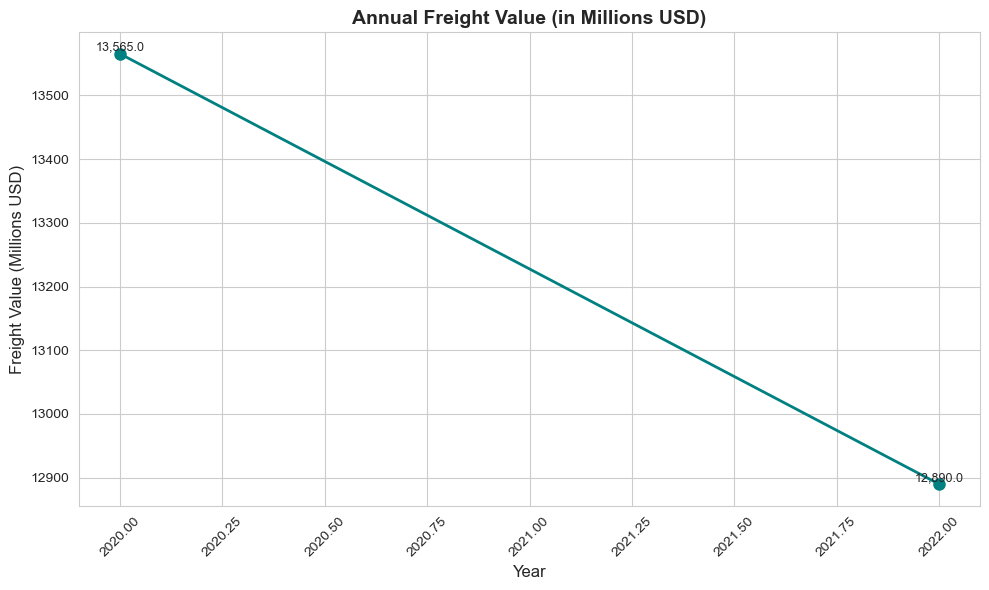

In [123]:
freight_year = df.groupby('YEAR')['FREIGHT_MILLIONS'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(freight_year['YEAR'], freight_year['FREIGHT_MILLIONS'], 
         marker='o', linestyle='-', linewidth=2, markersize=8, color='teal')

# Data labels (horizontal)
for i in range(len(freight_year)):
    plt.text(freight_year['YEAR'][i], 
             freight_year['FREIGHT_MILLIONS'][i] + 0.5,
             f"{freight_year['FREIGHT_MILLIONS'][i]:,.1f}", 
             ha='center', va='bottom', fontsize=9)

plt.title('Annual Freight Value (in Millions USD)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Freight Value (Millions USD)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


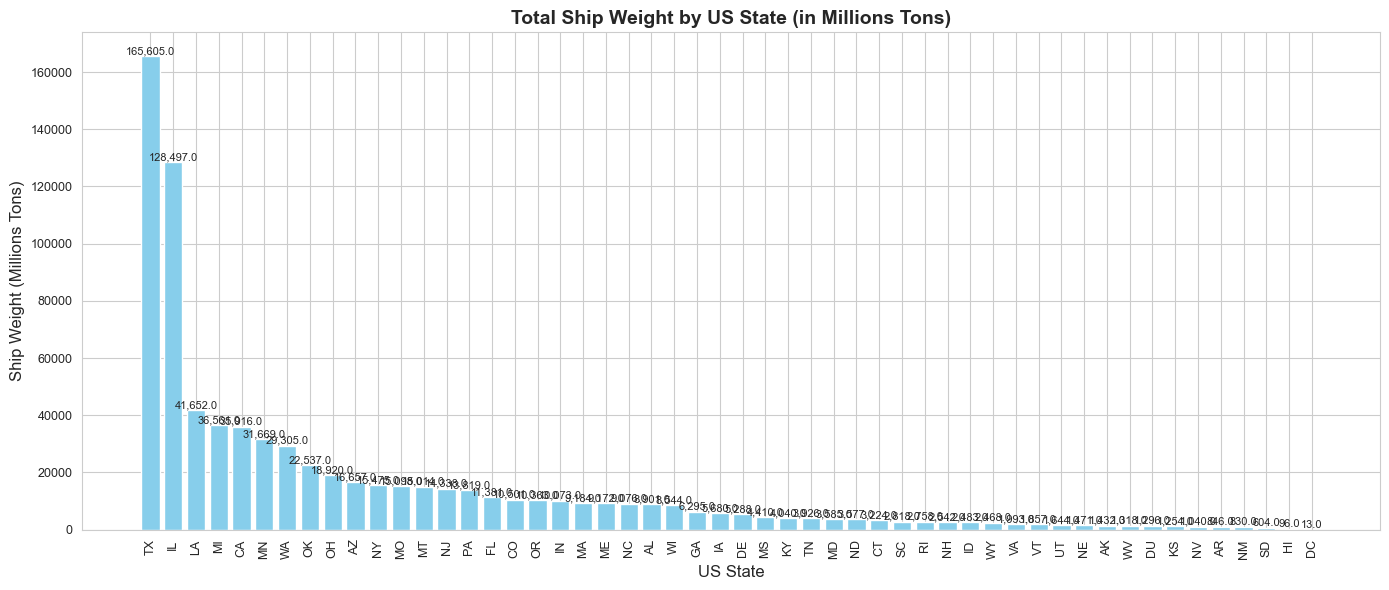

In [141]:
import matplotlib.pyplot as plt

# Prepare the data
shipwt_state = df.dropna(subset=['USASTATE']).groupby('USASTATE')['SHIPWT_MILLIONS'].sum().reset_index()
shipwt_state = shipwt_state.sort_values(by='SHIPWT_MILLIONS', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(shipwt_state['USASTATE'], shipwt_state['SHIPWT_MILLIONS'], color='skyblue')

# Data labels (horizontal)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,
             f'{height:,.1f}', ha='center', va='bottom', fontsize=8)

# Titles and labels
plt.title('Total Ship Weight by US State (in Millions Tons)', fontsize=14, fontweight='bold')
plt.xlabel('US State', fontsize=12)
plt.ylabel('Ship Weight (Millions Tons)', fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)

# No grid line included
plt.tight_layout()
plt.show()


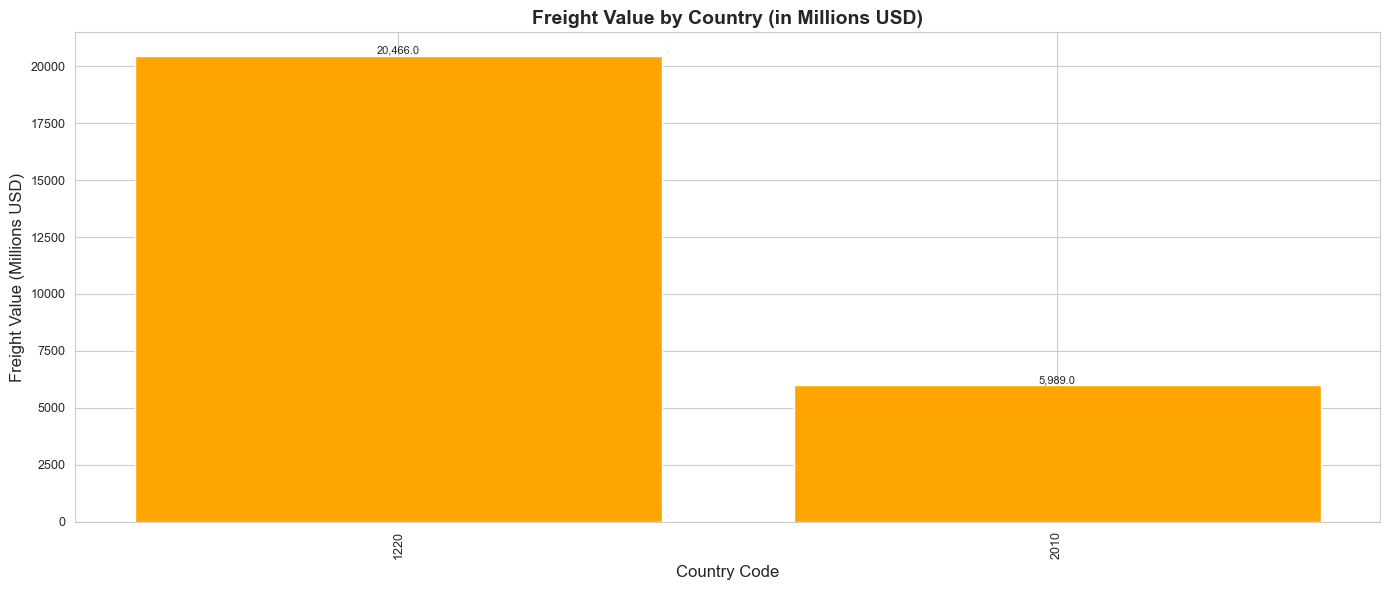

In [127]:
freight_country = df.groupby('COUNTRY')['FREIGHT_MILLIONS'].sum().reset_index()
freight_country = freight_country.sort_values(by='FREIGHT_MILLIONS', ascending=False)

plt.figure(figsize=(14, 6))
bars = plt.bar(freight_country['COUNTRY'].astype(str), freight_country['FREIGHT_MILLIONS'], color='orange')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f'{height:,.1f}', ha='center', va='bottom', fontsize=8)

plt.title('Freight Value by Country (in Millions USD)', fontsize=14, fontweight='bold')
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Freight Value (Millions USD)', fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


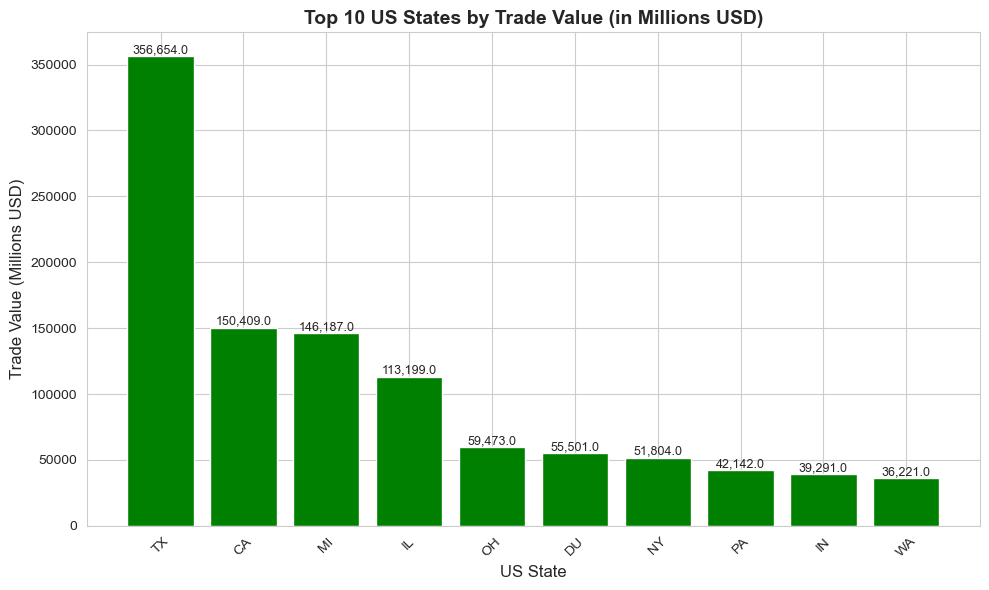

In [129]:
trade_by_state = df.dropna(subset=['USASTATE']).groupby('USASTATE')['VALUE_MILLIONS'].sum().reset_index()
top10_states = trade_by_state.sort_values(by='VALUE_MILLIONS', ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top10_states['USASTATE'], top10_states['VALUE_MILLIONS'], color='green')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f'{height:,.1f}', ha='center', va='bottom', fontsize=9)

plt.title('Top 10 US States by Trade Value (in Millions USD)', fontsize=14, fontweight='bold')
plt.xlabel('US State', fontsize=12)
plt.ylabel('Trade Value (Millions USD)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


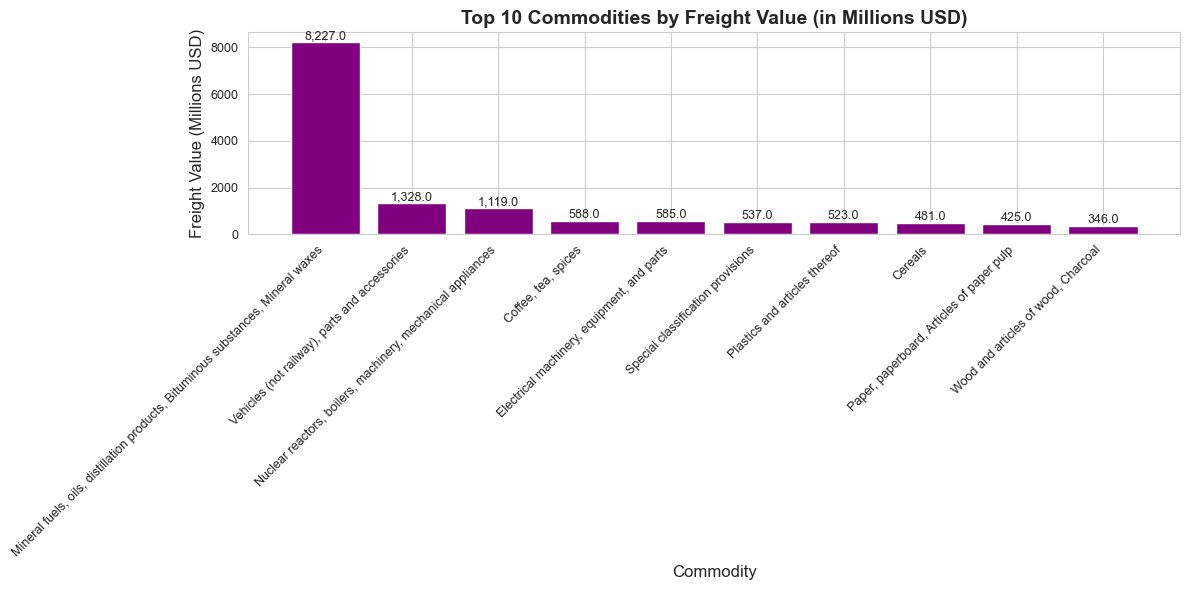

In [131]:
commodities = df.dropna(subset=['COMMODITY2'])
top_commodities = commodities.groupby('COMMODITY2')['FREIGHT_MILLIONS'].sum().reset_index()
top10_commodities = top_commodities.sort_values(by='FREIGHT_MILLIONS', ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(top10_commodities['COMMODITY2'], top10_commodities['FREIGHT_MILLIONS'], color='purple')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f'{height:,.1f}', ha='center', va='bottom', fontsize=9)

plt.title('Top 10 Commodities by Freight Value (in Millions USD)', fontsize=14, fontweight='bold')
plt.xlabel('Commodity', fontsize=12)
plt.ylabel('Freight Value (Millions USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


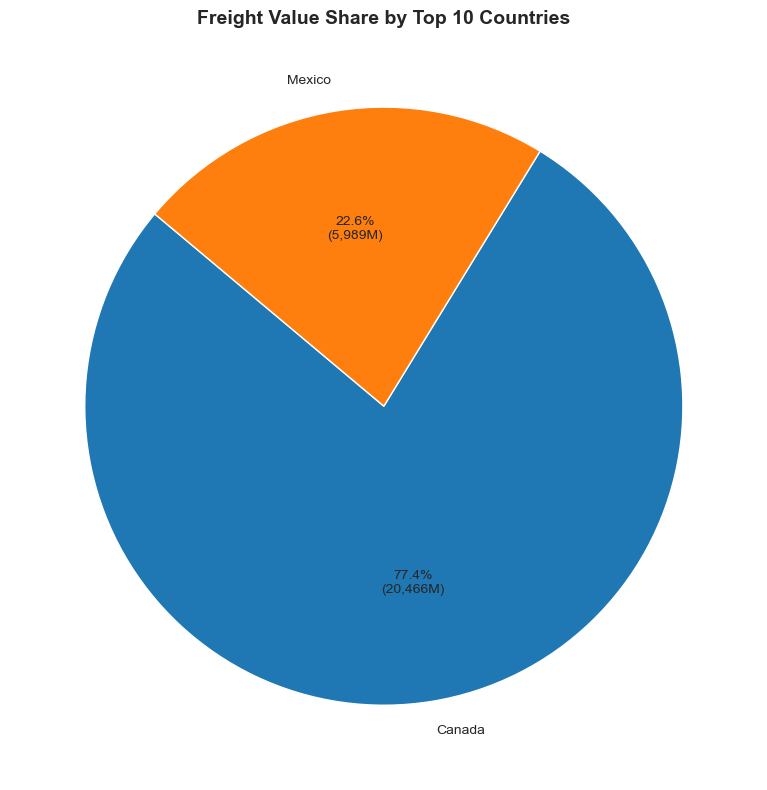

In [133]:
country_map = {1220: 'Canada', 2010: 'Mexico'}
freight_country = df.groupby('COUNTRY')['FREIGHT_MILLIONS'].sum().reset_index()
freight_country['COUNTRY_NAME'] = freight_country['COUNTRY'].map(country_map).fillna(freight_country['COUNTRY'].astype(str))
top_countries = freight_country.sort_values(by='FREIGHT_MILLIONS', ascending=False).head(10)

def autopct_format(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:,}M)"

plt.figure(figsize=(8, 8))
plt.pie(
    top_countries['FREIGHT_MILLIONS'],
    labels=top_countries['COUNTRY_NAME'],
    autopct=lambda pct: autopct_format(pct, top_countries['FREIGHT_MILLIONS']),
    startangle=140,
    textprops={'fontsize': 10}
)
plt.title('Freight Value Share by Top 10 Countries', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


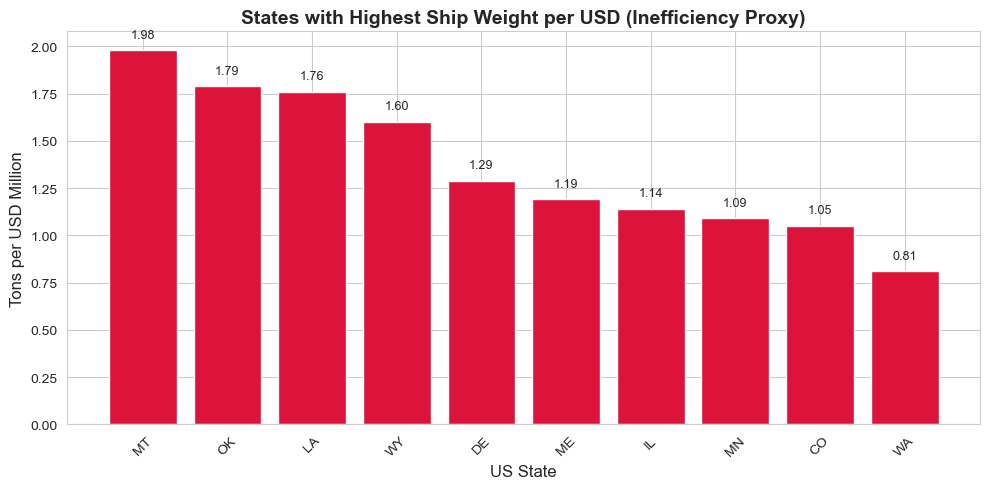

In [135]:
state_eff = df.dropna(subset=['USASTATE']).groupby('USASTATE')[['VALUE_MILLIONS', 'SHIPWT_MILLIONS']].sum()
state_eff['WT_PER_VALUE'] = (state_eff['SHIPWT_MILLIONS'] / state_eff['VALUE_MILLIONS']).round(2)
ineff_states = state_eff.sort_values(by='WT_PER_VALUE', ascending=False).head(10)

plt.figure(figsize=(10, 5))
bars = plt.bar(ineff_states.index, ineff_states['WT_PER_VALUE'], color='crimson')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.title('States with Highest Ship Weight per USD (Inefficiency Proxy)', fontsize=14, fontweight='bold')
plt.xlabel('US State', fontsize=12)
plt.ylabel('Tons per USD Million', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


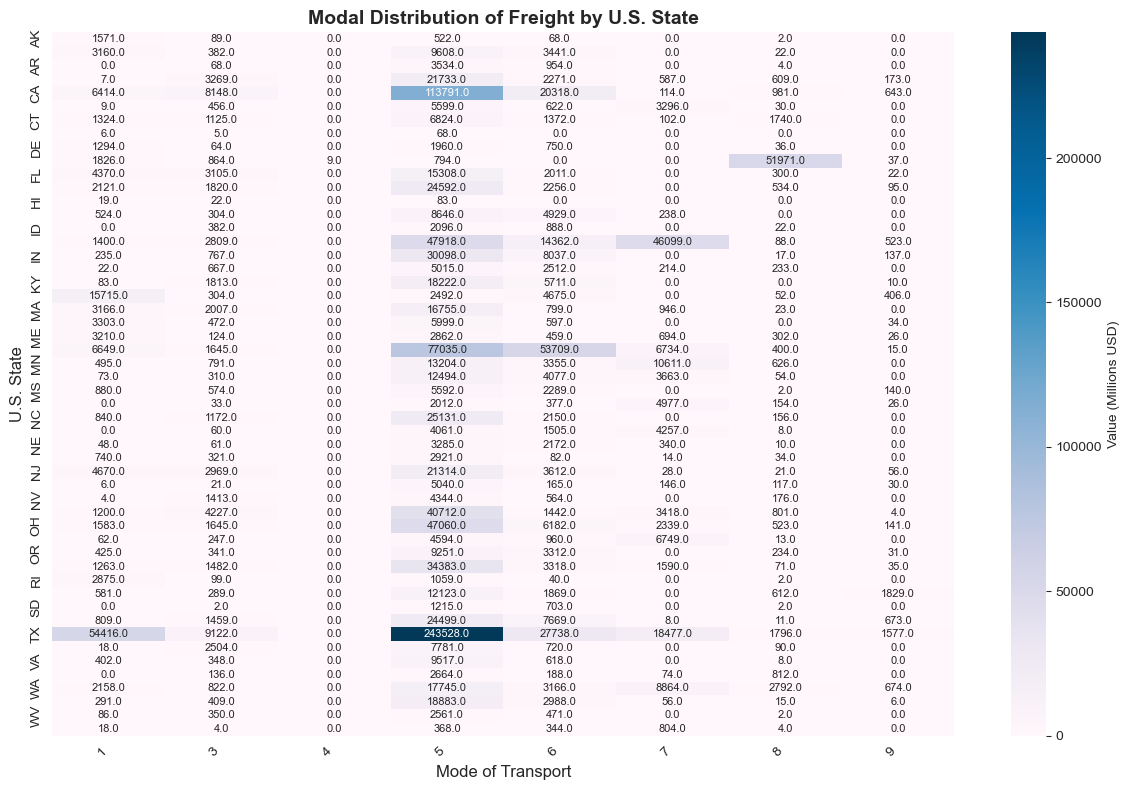

In [137]:
modal_diversity = df.pivot_table(index='USASTATE', columns='DISAGMOT', values='VALUE_MILLIONS', aggfunc='sum').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(
    modal_diversity,
    cmap='PuBu',
    linewidths=0,  # No grid lines
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 8},
    cbar_kws={'label': 'Value (Millions USD)'}
)

plt.title('Modal Distribution of Freight by U.S. State', fontsize=14, fontweight='bold')
plt.xlabel('Mode of Transport', fontsize=12)
plt.ylabel('U.S. State', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
